In [8]:
import struct
from struct import unpack
import numpy as np
import h5py
import pandas as pd
import os

from rasterio.features import rasterize
from shapely.geometry import LineString, MultiLineString, MultiPolygon
from shapely.affinity import scale, rotate

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        'key_id': key_id,
        'countrycode': countrycode,
        'recognized': recognized,
        'timestamp': timestamp,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break

In [21]:
df = pd.DataFrame()
for drawing in unpack_drawings('./data/octopus.bin'):
    df = df.append(drawing,ignore_index=True)
df.head()

,countrycode,image,key_id,recognized,timestamp
0,b'CZ',"[((67, 69, 74, 94, 105, 116, 119, 115, 120, 13...",4.599995e+15,1.0,1.488711e+09
1,b'CH',"[((99, 84, 80), (3, 25, 56)), ((93, 103, 116, ...",6.746257e+15,1.0,1.485207e+09
2,b'DE',"[((202, 191, 170, 153, 140, 130, 127, 136, 151...",5.419214e+15,1.0,1.490006e+09
3,b'SK',"[((0, 24, 42, 48, 48, 52, 66, 72, 88, 130, 152...",5.953291e+15,1.0,1.488577e+09
4,b'DE',"[((98, 91, 90, 99, 115, 129, 144, 144, 132), (...",5.005193e+15,1.0,1.485547e+09


In [31]:
def process_octopus(octopus):
    octopus = [list(zip(line[1],line[0])) for line in octopus]
    octopus = MultiLineString(octopus)
    octopus = MultiPolygon([LineString(line).buffer(1) for line in octopus])
    octopus = scale(octopus,xfact=225/256,yfact=225/256,origin='centroid')
    octopus = rasterize(octopus, out_shape=(256,256), all_touched=True)
    octopus = np.flipud(np.rot90(octopus))[...,np.newaxis]
    return octopus

filename = '256x256_octopuses'

if not os.path.isfile('./data/{}.hdf5'.format(filename)):
    h5py.File('./data/{}.hdf5'.format(filename),'w')
    print('Writing the file...')

with h5py.File('./data/{}.hdf5'.format(filename),'r+') as f:
    data = list(df[df.recognized == 1].image.values)
    f.require_dataset('rasters',shape=(len(data),256,256,1),dtype='int8')
    data = [process_octopus(octopus) for octopus in data]
    for i,octopus in enumerate(data):
        f['rasters'][i,...] = data[i]
    print('Done!')

Writing the file...


(143558, 256, 256, 1)


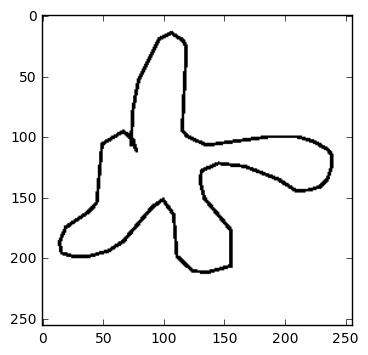

In [32]:
filename = '256x256_octopuses'
with h5py.File('./data/{}.hdf5'.format(filename),'r+') as f:
    print(f['rasters'].shape)
    plt.imshow(f['rasters'][0,:,:,0], cmap='Greys')
    #for name in f:
    #    print(name)